### 14.2. 텍스트 분석

IMDB 영화평 데이터셋 주소

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [1]:
using CSV, DataFrames
imdb = CSV.read("/home/tyfun/Downloads/IMDB Dataset.csv", DataFrame)

Row,review,sentiment
,String,String15
1,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
2,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
3,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
4,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Ra

In [2]:
combine(groupby(imdb, :sentiment), nrow)

Row,sentiment,nrow
,String15,Int64
1,positive,25000
2,negative,25000


In [3]:
using TextAnalysis
X_crps = Corpus(StringDocument.(imdb.review))

A Corpus with 50000 documents:
 * 50000 StringDocument's
 * 0 FileDocument's
 * 0 TokenDocument's
 * 0 NGramDocument's

Corpus's lexicon contains 0 tokens
Corpus's index contains 0 tokens

텍스트 전처리

In [4]:
prepare!(X_crps, strip_corrupt_utf8)
prepare!(X_crps, strip_case)
prepare!(X_crps, stem_words)
prepare!(X_crps, strip_non_letters)
prepare!(X_crps, strip_indefinite_articles)
prepare!(X_crps, strip_definite_articles)
prepare!(X_crps, strip_prepositions)
prepare!(X_crps, strip_pronouns)
prepare!(X_crps, strip_stopwords)
prepare!(X_crps, strip_html_tags)

In [5]:
using Languages
stopwords(Languages.English())

488-element Vector{String}:
 "a"
 "about"
 "above"
 "across"
 "after"
 "again"
 "against"
 "all"
 "almost"
 "alone"
 "along"
 "already"
 "also"
 ⋮
 "you'd"
 "you'll"
 "young"
 "younger"
 "youngest"
 "your"
 "you're"
 "yours"
 "yourself"
 "yourselves"
 "you've"
 "z"

In [6]:
sparseterms = Set(sparse_terms(X_crps, 0.01));
X = X_crps .|> text .|> tokenize;
X = map(r -> filter(v -> !in(v, sparseterms), r), X);

In [7]:
using MLJ
y = coerce(imdb.sentiment, Multiclass);
(X_train, X_test), (y_train, y_test) = 
    partition((X, y), 0.7, multi=true, rng=0);

특성 추출

In [8]:
CountTransformer = @load CountTransformer pkg=MLJText verbosity=0;
TfidfTransformer = @load TfidfTransformer pkg=MLJText verbosity=0;
BM25Transformer = @load BM25Transformer pkg=MLJText verbosity=0;

In [9]:
sample = [["아침", "식사", "아침", "커피"], ["점심", "식사"]]
trans = CountTransformer();
mach = machine(trans, sample);
MLJ.fit!(mach, verbosity=0);
feat = MLJ.transform(mach, sample);
cols = fitted_params(mach).vocab;
DataFrame(Matrix(feat), cols)

Row,식사,아침,점심,커피
,Int64,Int64,Int64,Int64
1,1,2,0,1
2,1,0,1,0


In [10]:
trans = TfidfTransformer();
mach = machine(trans, sample);
MLJ.fit!(mach, verbosity=0);
feat = MLJ.transform(mach, sample);
cols = fitted_params(mach).vocab;
DataFrame(Matrix(feat), cols)

Row,식사,아침,점심,커피
,Float64,Float64,Float64,Float64
1,0.25,0.702733,0.0,0.351366
2,0.5,0.0,0.702733,0.0


In [11]:
trans = BM25Transformer();
mach = machine(trans, sample);
MLJ.fit!(mach, verbosity=0);
feat = MLJ.transform(mach, sample);
cols = fitted_params(mach).vocab;
DataFrame(Matrix(feat), cols)

Row,식사,아침,점심,커피
,Float64,Float64,Float64,Float64
1,0.5,0.929636,0.0,0.702733
2,0.961132,0.0,1.35084,0.0


학습 및 예측

In [12]:
trans = CountTransformer();
mach = machine(trans, X_train);
MLJ.fit!(mach, verbosity=0);
X_train_mat = MLJ.transform(mach, X_train);
DataFrame([eachcol(X_train_mat)...], :auto, copycols=false)

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,⋯
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,⋯
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯
4,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯
9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯


In [13]:
MultinomialNB = @load MultinomialNBClassifier pkg=MLJScikitLearnInterface verbosity=0

    CondaPkg Found dependencies: /home/tyfun/.julia/packages/MLJScikitLearnInterface/GXjgk/CondaPkg.toml
    CondaPkg Found dependencies: /home/tyfun/.julia/packages/PythonCall/1f5yE/CondaPkg.toml
    CondaPkg Dependencies already up to date


MLJScikitLearnInterface.MultinomialNBClassifier

In [14]:
toDataFrame(x) = DataFrame([eachcol(Float64.(x))...], :auto, copycols=false)
model = CountTransformer() |> toDataFrame |> MultinomialNB();
mach = machine(model, X_train, y_train);
MLJ.fit!(mach, verbosity=0); 
accuracy(predict_mode(mach, X_test), y_test) 

0.8221333333333334

In [15]:
function run_batch(trans, clfs, X_tr, y_tr, X_te, y_te)
    accs = Float64[]
    for tran in trans
        for clf in clfs
            model = tran |> toDataFrame |> clf;
            mach = machine(model, X_tr, y_tr);
            MLJ.fit!(mach, verbosity=0)
            is_proba = prediction_type(clf) == :probabilistic
            oper = is_proba ? predict_mode : MLJ.predict
            pred = oper(mach, X_te)
            acc = accuracy(pred, y_te)
            println((clf, tran) => acc)
            push!(accs, acc)
        end
    end
    accs
end

run_batch (generic function with 1 method)

In [16]:
PCA = @load PCA pkg=MultivariateStats verbosity=0;
SVM = @load SVC pkg=LIBSVM verbosity=0;
Logistic = @load LogisticClassifier pkg=MLJLinearModels verbosity=0;

In [17]:
trans = [CountTransformer(), TfidfTransformer(), BM25Transformer()]
svm = PCA(variance_ratio=0.95) |> SVM()
clfs = [MultinomialNB(), Logistic(lambda=0.001), svm]
res = run_batch(trans, clfs, X_train, y_train, X_test, y_test)

(MultinomialNBClassifier(alpha = 1.0, …), CountTransformer(max_doc_freq = 1.0, …)) => 0.8221333333333334
(LogisticClassifier(lambda = 0.001, …), CountTransformer(max_doc_freq = 1.0, …)) => 0.8616
(DeterministicPipeline(pca = PCA(maxoutdim = 0, …), …), CountTransformer(max_doc_freq = 1.0, …)) => 0.8511333333333333
(MultinomialNBClassifier(alpha = 1.0, …), TfidfTransformer(max_doc_freq = 1.0, …)) => 0.8351333333333333
(LogisticClassifier(lambda = 0.001, …), TfidfTransformer(max_doc_freq = 1.0, …)) => 0.8283333333333334
(DeterministicPipeline(pca = PCA(maxoutdim = 0, …), …), TfidfTransformer(max_doc_freq = 1.0, …)) => 0.8613999999999999
(MultinomialNBClassifier(alpha = 1.0, …), BM25Transformer(max_doc_freq = 1.0, …)) => 0.8381333333333334
(LogisticClassifier(lambda = 0.001, …), BM25Transformer(max_doc_freq = 1.0, …)) => 0.8589333333333333
(DeterministicPipeline(pca = PCA(maxoutdim = 0, …), …), BM25Transformer(max_doc_freq = 1.0, …)) => 0.863


9-element Vector{Float64}:
 0.8221333333333334
 0.8616
 0.8511333333333333
 0.8351333333333333
 0.8283333333333334
 0.8613999999999999
 0.8381333333333334
 0.8589333333333333
 0.863

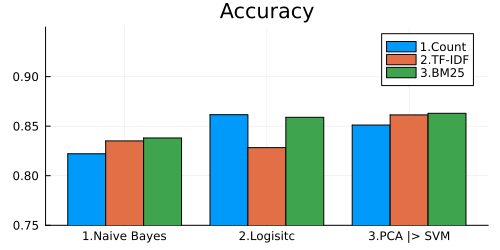

In [19]:
using StatsPlots
gr(size=(500,250))
clfnms = ["1.Naive Bayes", "2.Logisitc", "3.PCA |> SVM"];
group = repeat(["1.Count", "2.TF-IDF", "3.BM25"], inner=3);
x = repeat(clfnms, outer=3);
groupedbar(x, res, group=group, ylim=[0.75,0.95], title="Accuracy")